In [1]:
import sys
import copy
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from mods import prep, plotter
from scipy import optimize
%matplotlib inline
%load_ext autoreload

sys.path.append('./ligbind/')
import ligbind

In [2]:
WT_08_lbl, WT_08_rtot, WT_08_lig, WT_08_sat = prep.datprep('data/EGFR_WT_08_Sat.csv','Data/EGFR_WT_08_Rtot.csv')

hootie hoo! the indices match!


In [3]:
def lnlikelihood(parms,data,*modargs):
    datac = np.concatenate(data)
    lnf = parms[-1]
    model = ligbind.models.wymfunc(parms[:-1],*modargs)
    invsig2 = 1.0/(model**2*np.exp(2*lnf))
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log((1./(2.*np.pi))*invsig2)))

In [4]:
def lnprior(parms,bounds):
    k11,k21,k22,l20,lnf = parms
    k11_lo = bounds[0][0]
    k11_hi = bounds[0][1]
    k21_lo = bounds[1][0]
    k21_hi = bounds[1][1]
    k22_lo = bounds[2][0]
    k22_hi = bounds[2][1]
    l20_lo = bounds[3][0]
    l20_hi = bounds[3][1]
    lnf_lo = bounds[4][0]
    lnf_hi = bounds[4][1]
    if k11_lo < k11 < k11_hi and k21_lo < k21 < k22_hi and k22_lo < k22 < k22_hi and l20_lo < l20 < l20_hi and lnf_lo < lnf < lnf_hi:
        return 0.0
    return -np.inf

In [19]:
def lnprob_jn(parms,bounds,data,*modargs):
    lp = lnprior(parms,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(parms,data,*modargs)

In [57]:
bnds = ((0.0, 100.0), (0.0, 100.0), (0.0, 100.0), (0.0, 100000.0), (-10.0, 0.0))

In [6]:
nll = lambda *args: -lnlikelihood(*args)

In [54]:
guess = np.array([10.,5.,0.5,100.,-2.])

In [65]:
wt08nllfit = optimize.minimize(nll,guess,args=(WT_08_sat,WT_08_lig,WT_08_rtot),bounds=bnds)

In [66]:
wt08nllfit.x

array([  1.10356564e+01,   6.57935557e+00,   4.48262339e-01,
         1.73970542e+04,  -2.29600171e+00])

In [60]:
lsbnds = ((0.,0.,0.,0.),(100.,100.,100.,100000.))

In [61]:
fit = optimize.least_squares(ligbind.helpers.objfunc,guess[:-1],args=(ligbind.models.wymfunc,WT_08_sat,WT_08_lig,WT_08_rtot), bounds=lsbnds)

In [62]:
fit.x

array([   3.79530134,    5.44192218,    0.19625125,  170.10339262])

In [16]:
prefit = np.array([   3.79528092,    5.44194659,    0.19624479,  170.09679543,-2.])

In [14]:
ndim,nwalkers = 5,100

In [68]:
pos = [wt08nllfit.x + (np.random.randn(ndim)*[1e-1,1e-1,1e-2,1e1,1e-1]) for i in range(nwalkers)]

In [69]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob_jn,args=(bnds,WT_08_sat,WT_08_lig,WT_08_rtot))

In [70]:
sampler.run_mcmc(pos,1000)

(array([[  2.22976783e+01,   5.92555637e+00,   4.41572380e-01,
           6.16287474e+04,  -2.40910574e+00],
        [  1.90992077e+01,   6.36781220e+00,   4.17943962e-01,
           6.66085984e+04,  -2.36418017e+00],
        [  1.91191355e+01,   6.25291789e+00,   5.28266622e-01,
           8.01905451e+04,  -2.25373660e+00],
        [  1.25564590e+01,   6.49349806e+00,   2.26195091e-01,
           1.57520417e+04,  -2.10150828e+00],
        [  1.48815779e+01,   6.00115654e+00,   5.54798193e-01,
           3.71406084e+04,  -2.43533465e+00],
        [  1.65074916e+01,   6.35272389e+00,   5.39484815e-01,
           6.29111642e+04,  -2.30684488e+00],
        [  1.70405299e+01,   6.36941300e+00,   5.36282324e-01,
           6.89080254e+04,  -2.31832741e+00],
        [  2.14159018e+01,   6.58335332e+00,   5.32066654e-01,
           8.02242155e+04,  -2.32041710e+00],
        [  1.09919698e+01,   6.64563603e+00,   4.86256264e-01,
           1.93790834e+04,  -2.19186291e+00],
        [  8.024187

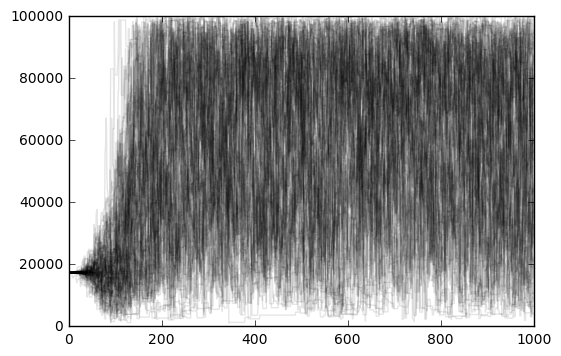

In [71]:
plt.plot(sampler.chain[:,:,3].T, '-', color='k', alpha=0.1);

In [72]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

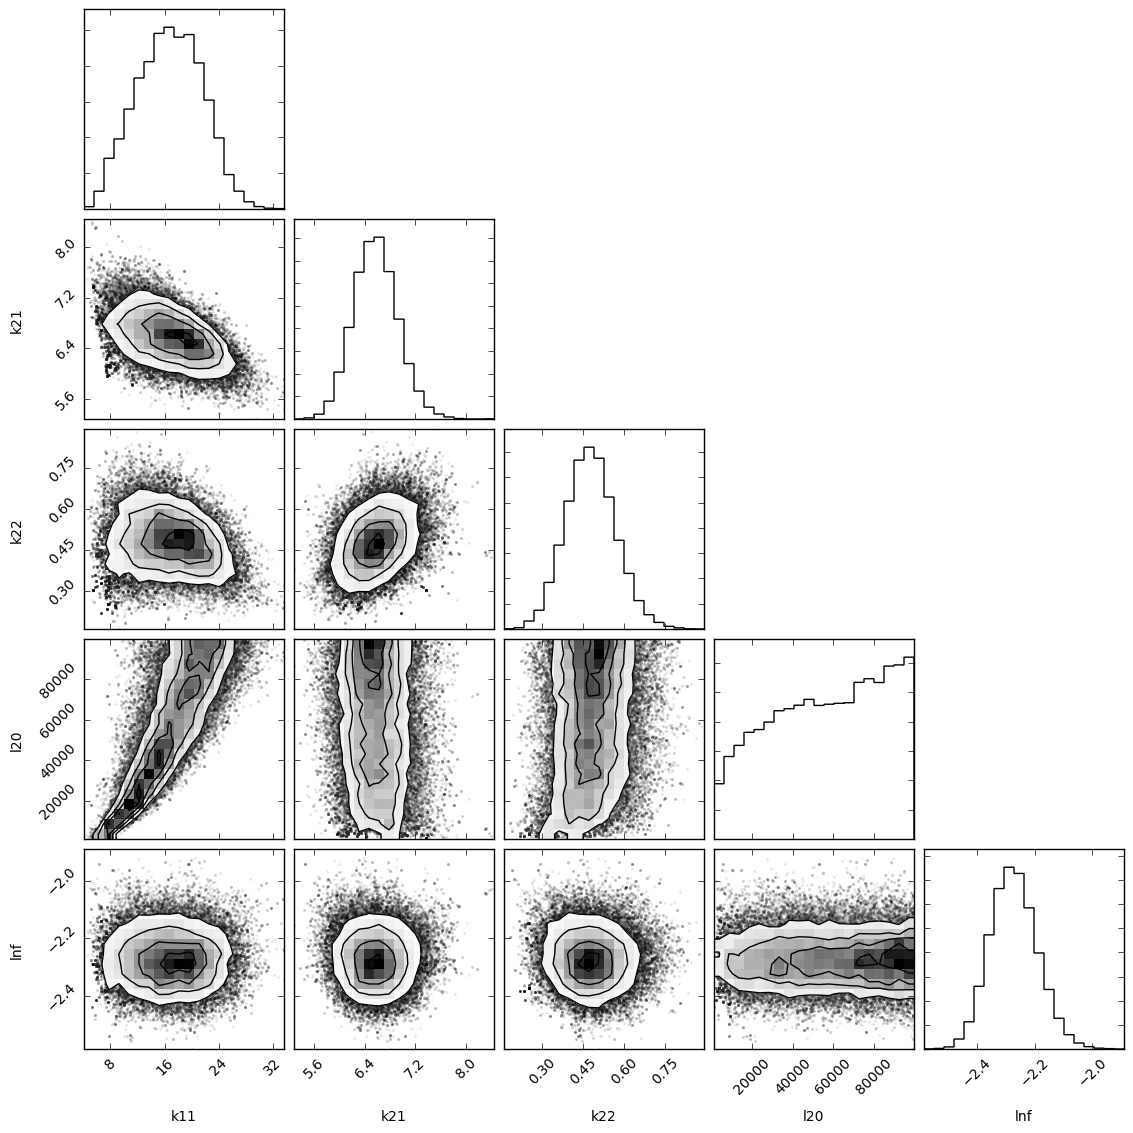

In [73]:
pic = corner.corner(samples,labels=['k11','k21','k22','l20','lnf'])

In [29]:
WT_08_lig_ed = np.delete(WT_08_lig,3)
WT_08_rtot_ed = np.delete(WT_08_rtot,3)
WT_08_sat_ed = np.delete(WT_08_sat,3)

In [36]:
fited = optimize.minimize(nll,guess,args=(WT_08_sat_ed,WT_08_lig_ed,WT_08_rtot_ed),bounds=bnds)

# fited.x

In [38]:
bnds1 = ((0.0, 100.0), (0.0, 100.0), (0.0, 100.0), (0.0, 10000.0), (-10.0, 0.0))

In [39]:
fited = optimize.minimize(nll,guess,args=(WT_08_sat_ed,WT_08_lig_ed,WT_08_rtot_ed),bounds=bnds1)

In [40]:
fited.x

array([  9.48109500e+00,   6.71022052e+00,   3.97378641e-01,
         1.00000000e+04,  -2.29325879e+00])

In [41]:
WT_09_lbl, WT_09_rtot, WT_09_lig, WT_09_sat = prep.datprep('data/EGFR_WT_09_Sat.csv','data/EGFR_WT_09_Rtot.csv')

hootie hoo! the indices match!


In [44]:
res = optimize.minimize(nll,guess,args=(WT_09_sat,WT_09_lig,WT_09_rtot),bounds=bnds)

/Users/michael/miniconda3/envs/fitter/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/Users/michael/miniconda3/envs/fitter/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract


In [45]:
bnds

((0.0, 100.0), (0.0, 100.0), (0.0, 100.0), (0.0, 1000.0), (-10.0, 0.0))

In [46]:
fit = optimize.least_squares(ligbind.helpers.objfunc,guess[:-1],args=(ligbind.models.wymfunc,WT_09_sat,WT_09_lig,WT_09_rtot), bounds=lsbnds)

In [47]:
fit.x

array([  4.40406692e+00,   1.92115558e+00,   1.97204644e-01,
         1.00000000e+03])

In [51]:
fit_wt09 = optimize.least_squares(ligbind.helpers.objfunc,guess[:-1],bounds=lsbnds,args=(ligbind.models.wymfunc,WT_09_sat,WT_09_lig,WT_09_rtot))

In [52]:
fit_wt09.x

array([  4.40406692e+00,   1.92115558e+00,   1.97204644e-01,
         1.00000000e+03])

In [85]:
def rtsolv(rtots,parms,ligs,data):
    datac = np.concatenate(data)
    return (ligbind.models.wymfunc(parms,ligs,rtots) - datac)

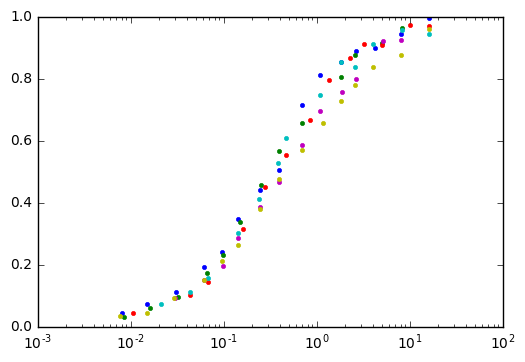

In [86]:
plotter.semlog(WT_08_lig,WT_08_sat,symb='.')

In [91]:
wt08_litparms = np.array([4.6,5.3,0.34,530.])

In [92]:
rtsolv(WT_08_rtot,wt08_litparms,WT_08_lig,WT_08_sat)

array([-0.01740799, -0.0206607 , -0.00976835, -0.01188224,  0.01045145,
       -0.01141733,  0.01320418,  0.06026973, -0.0270151 , -0.04181374,
       -0.00458064, -0.00304705,  0.02567486,  0.01349586, -0.01724201,
       -0.00175286, -0.00540371,  0.00432547,  0.00988487,  0.01566476,
       -0.0087546 , -0.01276428, -0.02144349,  0.00788486,  0.02452845,
       -0.00650372,  0.01042254, -0.01009578, -0.00958264,  0.02378302,
        0.03612123,  0.01638346, -0.0005144 ,  0.01484885,  0.01965084,
       -0.02493543, -0.02315243, -0.03071105,  0.01074289, -0.01619849,
        0.00173348, -0.00517401,  0.01857583,  0.02616626,  0.01311028,
        0.01056956,  0.00776938, -0.03126116, -0.00480073, -0.03001531,
        0.02937368, -0.00194262, -0.00599826,  0.03041262, -0.0116317 ,
        0.00239252,  0.01994538, -0.00769327, -0.00521469,  0.01212297,
        0.00850731, -0.01666098,  0.00871942,  0.01536787, -0.03444388,
       -0.00120259, -0.01421852, -0.00399386, -0.01403875, -0.00

In [93]:
WT_08_rtot

array([ 0.001439,  0.002422,  0.003392,  0.002718,  0.01216 ,  0.02594 ])

In [94]:
bndsrt = ((0.,0.,0.,0.,0.,0.,),(1.,1.,1.,1.,1.,1.))

In [95]:
guess = np.array([0.0005, 0.001, 0.005, 0.006, 0.03, 0.05])

In [96]:
res = optimize.least_squares(rtsolv,guess,args=(wt08_litparms,WT_08_lig,WT_08_sat),bounds=bndsrt)

In [97]:
res.x

array([ 0.00143878,  0.00242227,  0.00339179,  0.0027181 ,  0.01216361,
        0.02594479])

In [103]:
def lnlikRT(rtslv,data,modparms,ligs):
    datac = np.concatenate(data)
    lnf = rtslv[-1]
    model = ligbind.models.wymfunc(modparms,ligs,rtslv[:-1])
    print((model-datac))
    invsig2 = 1.0/(model**2*np.exp(2*lnf))
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log((1./(2.*np.pi))*invsig2)))

In [104]:
nuprm = np.array([ 0.00143878,  0.00242227,  0.00339179,  0.0027181 ,  0.01216361,
        0.02594479, -2.])

In [105]:
lnlikRT(nuprm,WT_08_sat,wt08_litparms,WT_08_lig)

[-0.01740759 -0.02065999 -0.00976696 -0.01187981  0.0104548  -0.011413
  0.01320971  0.060276   -0.02700869 -0.04180784 -0.00457587 -0.00304311
  0.02567773  0.01349756 -0.01724108 -0.00175315 -0.00540424  0.00432447
  0.00988306  0.01566232 -0.0087578  -0.01276844 -0.0214483   0.00787973
  0.02452429 -0.00650727  0.01042023 -0.01009738 -0.00958245  0.0237837
  0.0361222   0.01638524 -0.00051206  0.01485162  0.01965374 -0.02493271
 -0.02315017 -0.03070915  0.01074432 -0.01619763  0.00173404 -0.00517423
  0.01857541  0.02616566  0.01310926  0.01056823  0.0077678  -0.0312628
 -0.00480237 -0.03001672  0.02937247 -0.00194354 -0.00599881  0.03041231
 -0.01163335  0.00238941  0.01994088 -0.00769917 -0.00522287  0.0121128
  0.00849534 -0.01667341  0.00870771  0.01535729 -0.03445157 -0.00120832
 -0.01421873 -0.00399427 -0.01403952 -0.00759569 -0.00891565  0.00185875
 -0.01243058 -0.02084722 -0.00735563  0.00612164  0.0064056   0.00660133
  0.00736508  0.03288386 -0.01101569]


132.34207654430557

In [106]:
bndsml = ((0.,1),(0.1),(0.1),(0.,1),(0.1),(0.1),(-10.,0.))

In [ ]:
def lnprior(parms,bounds):
    k11,k21,k22,l20,lnf = parms
    k11_lo = bounds[0][0]
    k11_hi = bounds[0][1]
    k21_lo = bounds[1][0]
    k21_hi = bounds[1][1]
    k22_lo = bounds[2][0]
    k22_hi = bounds[2][1]
    l20_lo = bounds[3][0]
    l20_hi = bounds[3][1]
    lnf_lo = bounds[4][0]
    lnf_hi = bounds[4][1]
    if k11_lo < k11 < k11_hi and k21_lo < k21 < k22_hi and k22_lo < k22 < k22_hi and l20_lo < l20 < l20_hi and lnf_lo < lnf < lnf_hi:
        return 0.0
    return -np.inf

In [107]:
def lnpri2(rtsolve,bounds):
    for i in range(len(rtsolve)):
        if bounds[i][0] < rtsolve[i] < bounds[i][1]:
            return 0.0
        else:
            return -np.inf

In [108]:
lnpri2(wt08nllfit.x,bnds)

0.0

In [115]:
bndtest = np.array([1.,1.,1.,1.,1.,-1.])

In [116]:
lnpri2(bndtest,bnds)

0.0

In [117]:
bnds

((0.0, 100.0), (0.0, 100.0), (0.0, 100.0), (0.0, 100000.0), (-10.0, 0.0))

In [156]:
def lnpri3(rtsolve,bounds):
    assert len(bounds) == len(rtsolve)
    if all([bounds[i][0] < rtsolve[i] < bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf


In [166]:
lnpri3(bndtest,bnds)

-inf

In [165]:
bndtest = np.array([ 1.,  1.,  1.,  1., 1.])

In [177]:
a = np.array([lnpri3(np.random.randn(5),bnds) for i in range(1000)])

In [179]:
lnprior(bndtest,bnds)

-inf

In [192]:
testsets = [np.random.randn(5) for i in range(10000000)]

In [193]:
a = [lnprior(i,bnds) for i in testsets]

In [189]:
b = [lnpri3(i,bnds) for i in testsets]

In [190]:
a == b

True

In [191]:
a.count(0.0)/len(a)

0.0321

In [194]:
del(testsets)

In [195]:
del(a)

In [196]:
a

NameError: name 'a' is not defined